In [1]:
import tensorflow as tf
import numpy as np 

np.random.seed(17)
tf.random.set_seed(17)

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is NOT AVAILABLE


In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype('float32') / 255

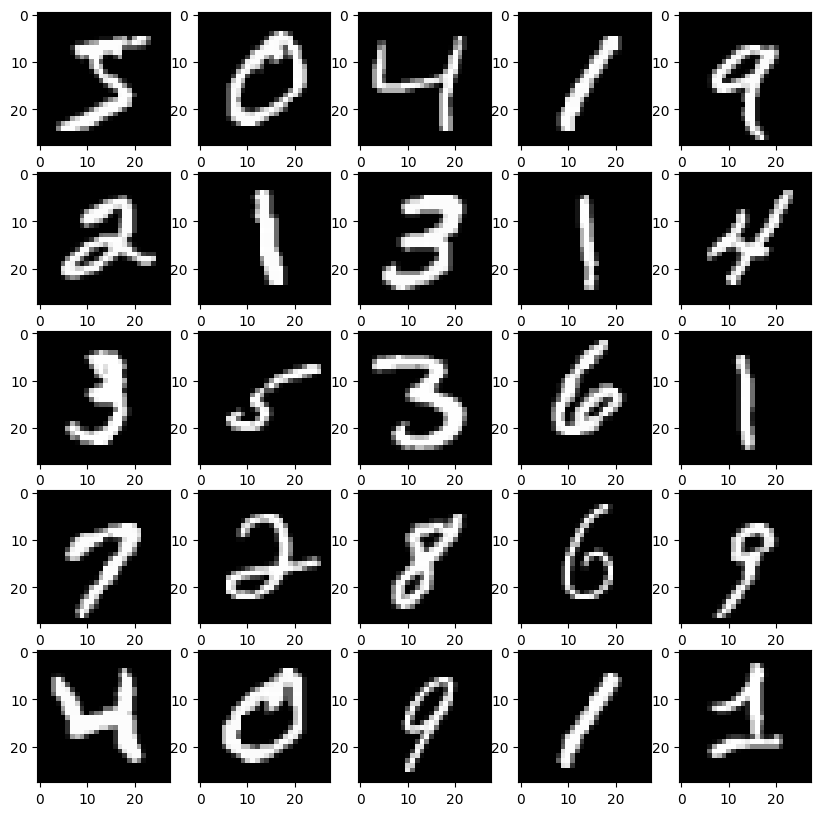

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(all_digits[i], cmap=plt.cm.gray)
plt.show()

In [6]:
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

dataset = tf.data.Dataset.from_tensor_slices(all_digits)

batch_size = 64
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

In [7]:
discriminator = tf.keras.Sequential([
    tf.keras.Input(shape=(28,28,1)),
    
    tf.keras.layers.Conv2D(64, (3, 3), strides=(1,1), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=.2),
    
    tf.keras.layers.Conv2D(128, (3, 3), strides=(1,1), padding='same'),
    
    tf.keras.layers.GlobalMaxPooling2D(),
    
    tf.keras.layers.Dense(1),
    ], 
    name='discriminator',
)

In [8]:
latent_dim = 128

In [9]:
generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim)),

        tf.keras.layers.Dense(14*14*128),
        tf.keras.layers.LeakyReLU(.2),

        tf.keras.layers.Reshape((14,14,128)),

        tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(1,1), padding='same'),
        tf.keras.layers.LeakyReLU(alpha=.2),

        tf.keras.layers.UpSampling2D(size=(2,2)),
        
        tf.keras.layers.Conv2D(1, (7,7), padding='same', activation='sigmoid'),
                           
    ],
    
        name = 'generator',

)

In [10]:
class GAN(tf.keras.Model):
    
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
            
        batch_size = tf.shape(real_images)[0]
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        generated_images = self.generator(random_latent_vectors)
        
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))] , axis=0
        )
        
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            
            predictions = self.discriminator(combined_images)
            
            d_loss = self.loss_fn(labels, predictions)
        
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        return {'d_loss:': d_loss, 'g_loss:': g_loss}

In [11]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

In [12]:
gan.built = True

In [13]:
gan.summary()

Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator (Sequential)  (None, 1)                 74625     
                                                                 
 generator (Sequential)      (None, 28, 28, 1)         3313281   
                                                                 
Total params: 3,387,906
Trainable params: 3,387,906
Non-trainable params: 0
_________________________________________________________________


In [14]:
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

In [15]:
import os
os.mkdir('images_hw')

In [16]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=5, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        
        generated_images = self.model.generator(random_latent_vectors)
        
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f'images_hw/{epoch}_img_{i}.png')

In [ ]:
%%time

img_monitoring = GANMonitor(num_img=5, latent_dim=latent_dim)

epochs = 30

gan.fit(
    dataset,
    epochs=epochs,
    callbacks=[img_monitoring]
)

Epoch 1/30


2023-04-10 17:59:43.666493: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1094/1094 [==============================] - 1405s 1s/step - d_loss:: 0.5870 - g_loss:: 0.9494
Epoch 2/30
 249/1094 [=====>........................] - ETA: 10:19 - d_loss:: 0.5897 - g_loss:: 1.0020

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 250))
for epoch in range(epochs):
    for i in range(5):
        plt.subplot(epochs, 5, 5 * epoch + i + 1)
        img_name = 'images/' + str(epoch) + '_img_' + str(i) + '.png'
        img = tf.keras.preprocessing.image.load_img(img_name, target_size=(28, 28))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img.astype("float32") / 255
        plt.imshow(img, cmap=plt.cm.gray)
        plt.xlabel(img_name)
plt.show()

In [ ]:
res = generator(tf.zeros(shape=(1,128)))

In [ ]:
# res

In [ ]:
img = tf.keras.preprocessing.image.array_to_img(res[0])
img.show()